FIRST INITIALIZATION

In [ ]:
%pip install momentfm

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from momentfm.utils.anomaly_detection_metrics import adjbestf1
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import glob

d:\Users\arian\anaconda3\Lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
from momentfm import MOMENTPipeline
# Initialize the MOMENT model
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={"task_name": "reconstruction"},
)
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

ZERO-SHOT ANNOMALY DETECTION FOR C-1.NPY

In [3]:
# Path to  C-1.npy
Conepath = 'H:/UNIVERSITY/Deep learning/Deep project/Dataset/data/data/test/C-1.npy'

# Load the data
data_cone = np.load(Conepath)

data_tensor_cone = torch.tensor(data_cone, dtype=torch.float)  # Convert to PyTorch tensor

In [4]:
data_tensor_cone.shape

torch.Size([2264, 55])

In [5]:
data_tensor_reshaped_cone = data_tensor_cone.unsqueeze(0).permute(0, 2, 1)
# data_tensor_reshaped now has shape [1, 55, 2264]

print(f"Original Shape: {data_tensor_cone.shape}")
print(f"Reshaped Shape: {data_tensor_reshaped_cone.shape}")

Original Shape: torch.Size([2264, 55])
Reshaped Shape: torch.Size([1, 55, 2264])


In [6]:
# Move tensor to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor_reshaped = data_tensor_reshaped_cone.to(device)

In [7]:
# Perform inference
with torch.no_grad():
    output_cone = model(data_tensor_reshaped_cone)

In [8]:
print(output_cone)

TimeseriesOutputs(forecast=None, anomaly_scores=None, logits=None, labels=None, input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.]]), pretrain_mask=tensor([[1, 1, 1,  ..., 1, 1, 1]]), reconstruction=tensor([[[-6.7912e-01, -7.0995e-01, -7.5672e-01,  ..., -7.0074e-01,
          -7.1400e-01, -7.0996e-01],
         [ 9.3886e-07, -3.6986e-07, -9.8772e-07,  ...,  1.3250e-06,
           6.8210e-07,  1.0574e-06],
         [ 9.3886e-07, -3.6986e-07, -9.8772e-07,  ...,  1.3250e-06,
           6.8210e-07,  1.0574e-06],
         ...,
         [ 9.3886e-07, -3.6986e-07, -9.8772e-07,  ...,  1.3250e-06,
           6.8210e-07,  1.0574e-06],
         [ 9.3886e-07, -3.6986e-07, -9.8772e-07,  ...,  1.3250e-06,
           6.8210e-07,  1.0574e-06],
         [ 9.3886e-07, -3.6986e-07, -9.8772e-07,  ...,  1.3250e-06,
           6.8210e-07,  1.0574e-06]]]), embeddings=None, metadata=None, illegal_output=None)


In [9]:
reconstruction_cone = output_cone.reconstruction.squeeze().cpu().numpy()  # Reconstructed values
print(reconstruction_cone)

[[-6.7911792e-01 -7.0995486e-01 -7.5671870e-01 ... -7.0073652e-01
  -7.1399659e-01 -7.0995927e-01]
 [ 9.3886297e-07 -3.6985932e-07 -9.8771659e-07 ...  1.3249614e-06
   6.8210102e-07  1.0573521e-06]
 [ 9.3886297e-07 -3.6985932e-07 -9.8771659e-07 ...  1.3249614e-06
   6.8210102e-07  1.0573521e-06]
 ...
 [ 9.3886297e-07 -3.6985932e-07 -9.8771659e-07 ...  1.3249614e-06
   6.8210102e-07  1.0573521e-06]
 [ 9.3886297e-07 -3.6985932e-07 -9.8771659e-07 ...  1.3249614e-06
   6.8210102e-07  1.0573521e-06]
 [ 9.3886297e-07 -3.6985932e-07 -9.8771659e-07 ...  1.3249614e-06
   6.8210102e-07  1.0573521e-06]]


In [10]:
trues_cone = data_tensor_reshaped_cone.squeeze().cpu().numpy() 
preds_cone = reconstruction_cone # Original data

In [13]:
# Calculate anomaly scores
anomaly_scores_cone = np.mean(np.square(trues_cone - preds_cone), axis=0)

# Initialize labels
labels = np.zeros(trues_cone.shape[1])  # Initialize labels
labels[550:750] = 1
labels[2100:2210] = 1

# Calculate the zero-shot adjusted best F1 score
adjusted_best_f1_cone = adjbestf1(y_true=labels, y_scores=anomaly_scores_cone)
print(f"Zero-shot Adjusted Best F1 Score For C-1: {adjusted_best_f1_cone}")



Zero-shot Adjusted Best F1 Score For C-1: 0.9480072169645709


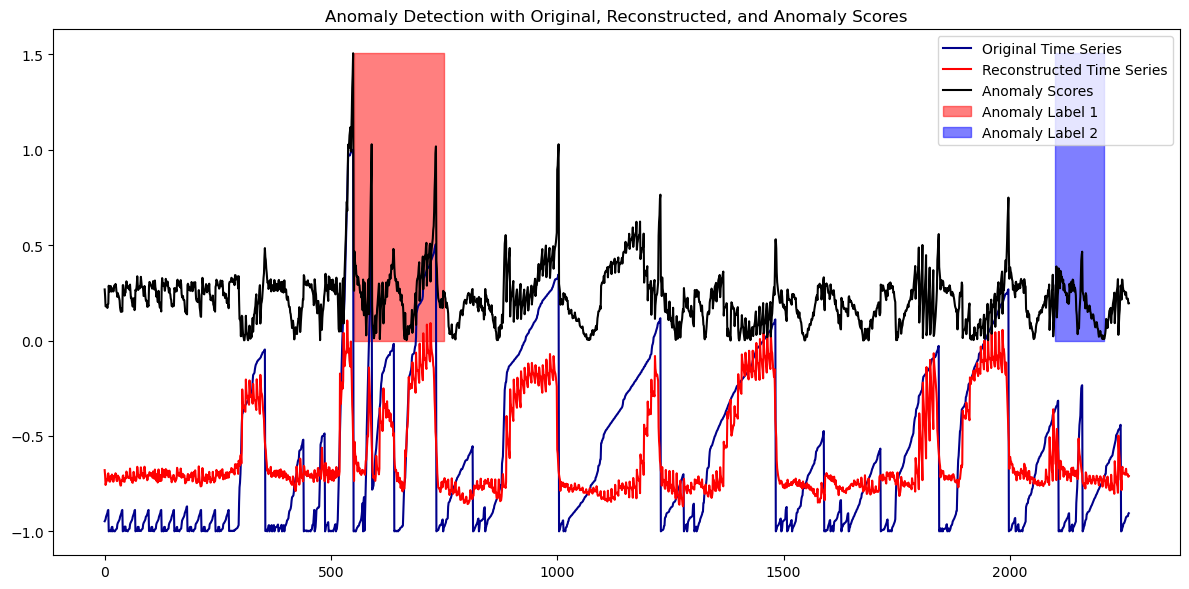

In [14]:
anomaly_scores = np.abs(trues_cone - preds_cone)

# Define start and end indices for visualization
anomaly_start1, anomaly_end1 = 550, 750
anomaly_start2, anomaly_end2 = 2100, 2210

# Plotting trues, preds, and anomaly scores in one image
plt.figure(figsize=(12, 6))

# Plotting original time series (trues)
plt.plot(trues_cone[0, :], label='Original Time Series', c='darkblue')

# Plotting reconstructed time series (preds)
plt.plot(preds_cone[0, :], label='Reconstructed Time Series', c='red')

# Plotting anomaly scores
plt.plot(anomaly_scores[0, :], label='Anomaly Scores', c='black')

# Highlighting anomalies based on labels
plt.fill_between(range(anomaly_start1, anomaly_end1), min(anomaly_scores[0, :]), max(anomaly_scores[0, :]), 
                 where=(anomaly_scores[0, anomaly_start1:anomaly_end1] > 0), color='red', alpha=0.5, label='Anomaly Label 1')

plt.fill_between(range(anomaly_start2, anomaly_end2), min(anomaly_scores[0, :]), max(anomaly_scores[0, :]), 
                 where=(anomaly_scores[0, anomaly_start2:anomaly_end2] > 0), color='blue', alpha=0.5, label='Anomaly Label 2')

plt.title('Anomaly Detection with Original, Reconstructed, and Anomaly Scores')
plt.legend()
plt.tight_layout()
plt.show()

ZERO-SHOT ANNOMALY DETECTION FOR M-7.NPY

In [54]:
# Load the data
Msevenpath = 'H:/UNIVERSITY/Deep learning/Deep project/Dataset/data/data/test/M-7.npy'
data_mseven = np.load(Msevenpath)

# Convert to PyTorch tensor
data_tensor_mseven = torch.tensor(data_mseven, dtype=torch.float)

# Reshape the tensor
data_tensor_reshaped_mseven = data_tensor_mseven.unsqueeze(0).permute(0, 2, 1)

print(f"Original Shape: {data_tensor_mseven.shape}")
print(f"Reshaped Shape: {data_tensor_reshaped_mseven.shape}")

Original Shape: torch.Size([2156, 55])
Reshaped Shape: torch.Size([1, 55, 2156])


In [55]:
# Move tensor to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor_reshaped_mseven = data_tensor_reshaped_mseven.to(device)

In [58]:
print(data_tensor_reshaped_mseven.shape)

torch.Size([1, 55, 3416])


In [59]:
# Perform inference
with torch.no_grad():
    output_mseven = model(data_tensor_reshaped_mseven)

print(output_mseven)


d:\Users\arian\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
d:\Users\arian\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TimeseriesOutputs(forecast=None, anomaly_scores=None, logits=None, labels=None, input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.]]), pretrain_mask=tensor([[1, 1, 1,  ..., 1, 1, 1]]), reconstruction=tensor([[[-6.5145e-01, -7.3317e-01, -8.0544e-01,  ..., -6.1316e-01,
          -5.8401e-01, -7.6270e-01],
         [-2.0605e-07, -5.3408e-08, -3.1071e-07,  ..., -2.3656e-07,
           2.6878e-06,  1.5427e-06],
         [ 1.7667e-07, -5.4005e-07, -1.2834e-06,  ...,  9.0943e-07,
           5.5761e-07,  1.8518e-06],
         ...,
         [ 4.9406e-08, -1.1443e-07, -2.8230e-07,  ..., -3.2555e-07,
           5.5230e-07,  2.9574e-06],
         [-3.0743e-03, -1.9356e-03, -2.7036e-03,  ...,  1.9641e-03,
          -7.2704e-04,  3.3298e-03],
         [-5.4788e-04,  8.6319e-03,  2.5440e-04,  ...,  2.4245e-02,
          -3.1734e-03, -2.7099e-03]]]), embeddings=None, metadata=None, illegal_output=None)


In [81]:
# Extract reconstructed values
reconstruction_mseven = output_mseven.reconstruction.squeeze().cpu().numpy()  # Reconstructed values
print(reconstruction_mseven)

[[-6.5145183e-01 -7.3316884e-01 -8.0543947e-01 ... -6.1315984e-01
  -5.8401477e-01 -7.6269925e-01]
 [-2.0605360e-07 -5.3407856e-08 -3.1071482e-07 ... -2.3656033e-07
   2.6877992e-06  1.5427106e-06]
 [ 1.7667418e-07 -5.4005176e-07 -1.2834483e-06 ...  9.0942535e-07
   5.5761438e-07  1.8518334e-06]
 ...
 [ 4.9405685e-08 -1.1442802e-07 -2.8230079e-07 ... -3.2554647e-07
   5.5230134e-07  2.9573696e-06]
 [-3.0742893e-03 -1.9356144e-03 -2.7035903e-03 ...  1.9640783e-03
  -7.2704104e-04  3.3297567e-03]
 [-5.4788426e-04  8.6318636e-03  2.5439658e-04 ...  2.4244772e-02
  -3.1734307e-03 -2.7099473e-03]]


In [82]:
# Original data
trues_mseven = data_tensor_reshaped_mseven.squeeze().cpu().numpy() 
preds_mseven = reconstruction_mseven 

In [83]:
# Calculate anomaly scores
anomaly_scores_mseven = np.mean(np.square(trues_mseven - preds_mseven), axis=0)

In [84]:
# Initialize labels
labels_mseven = np.zeros(trues_mseven.shape[1])  # Initialize labels
labels_mseven[940:1040] = 1  # Anomaly range

In [85]:
# Calculate the zero-shot adjusted best F1 score
adjusted_best_f1_mseven = adjbestf1(y_true=labels_mseven, y_scores=anomaly_scores_mseven)
print(f"Zero-shot Adjusted Best F1 Score For M-7: {adjusted_best_f1_mseven}")

Zero-shot Adjusted Best F1 Score For M-7: 0.9999949000250098


In [86]:
# Calculate absolute anomaly scores for visualization
anomaly_scores_abs_mseven = np.abs(trues_mseven - preds_mseven)

# Define start and end indices for visualization
anomaly_start_mseven, anomaly_end_mseven = 940, 1040

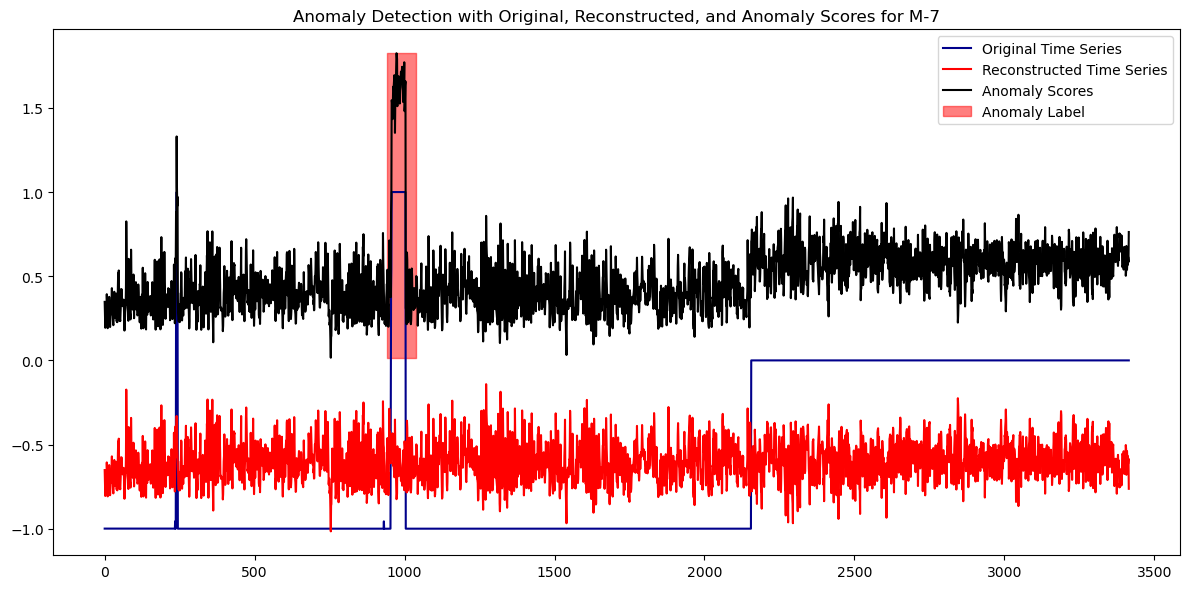

In [87]:
# Plotting trues, preds, and anomaly scores in one image
plt.figure(figsize=(12, 6))

# Plotting original time series (trues)
plt.plot(trues_mseven[0, :], label='Original Time Series', c='darkblue')

# Plotting reconstructed time series (preds)
plt.plot(preds_mseven[0, :], label='Reconstructed Time Series', c='red')

# Plotting anomaly scores
plt.plot(anomaly_scores_abs_mseven[0, :], label='Anomaly Scores', c='black')

# Highlighting anomalies based on labels
plt.fill_between(range(anomaly_start_mseven, anomaly_end_mseven), min(anomaly_scores_abs_mseven[0, :]), max(anomaly_scores_abs_mseven[0, :]), 
                 where=(anomaly_scores_abs_mseven[0, anomaly_start_mseven:anomaly_end_mseven] > 0), color='red', alpha=0.5, label='Anomaly Label')

plt.title('Anomaly Detection with Original, Reconstructed, and Anomaly Scores for M-7')
plt.legend()
plt.tight_layout()
plt.show()

ZERO-SHOT ANNOMALY DETECTION FOR S-2.NPY

In [115]:
# Load the data
S2path = 'H:/UNIVERSITY/Deep learning/Deep project/Dataset/data/data/test/S-2.npy'
data_S2 = np.load(S2path)

# Convert to PyTorch tensor
data_tensor_S2 = torch.tensor(data_S2, dtype=torch.float)

# Reshape the tensor
data_tensor_reshaped_S2 = data_tensor_S2.unsqueeze(0).permute(0, 2, 1)

print(f"Original Shape: {data_tensor_S2.shape}")
print(f"Reshaped Shape: {data_tensor_reshaped_S2.shape}")


Original Shape: torch.Size([1827, 55])
Reshaped Shape: torch.Size([1, 55, 1827])


In [116]:
# Move tensor to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor_reshaped_M5 = data_tensor_reshaped_S2.to(device)
print(data_tensor_reshaped_S2.shape)

torch.Size([1, 55, 1827])


In [118]:
data_tensor_reshaped_S2 = data_tensor_reshaped_S2[:, :, :1824]
print(f"Truncated shape: {data_tensor_reshaped_S2.shape}")# Perform inference
with torch.no_grad():
    output_S2 = model(data_tensor_reshaped_S2)

Truncated shape: torch.Size([1, 55, 1824])


d:\Users\arian\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
d:\Users\arian\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [119]:
# Extract reconstructed values
reconstruction_S2 = output_S2.reconstruction.squeeze().cpu().numpy()  # Reconstructed values
print(reconstruction_S2)

[[-9.9373847e-01 -9.9852425e-01 -9.9891609e-01 ... -9.7908729e-01
  -9.8958814e-01 -9.8142570e-01]
 [ 7.2142660e-07 -9.0831134e-07  8.2288494e-07 ... -1.1399206e-06
   8.8075961e-07  5.9620857e-06]
 [ 1.7212318e-06 -3.3821709e-07  7.3339191e-07 ...  1.8667913e-07
   1.1076722e-06  7.9151835e-07]
 ...
 [ 2.3860528e-06 -2.1364301e-06 -1.0058823e-06 ...  1.1966490e-06
   2.5042339e-06  3.1936830e-07]
 [ 5.6692734e-03 -1.7471719e-03  5.0332360e-03 ...  3.7315544e-03
   3.9609149e-03  1.5167594e-02]
 [ 3.6673136e-03 -4.2337030e-03 -2.3070110e-03 ...  5.6532859e-03
   3.1856857e-03  1.8446023e-02]]


In [120]:
# Original data
trues_S2 = data_tensor_reshaped_S2.squeeze().cpu().numpy() 
preds_S2 = reconstruction_S2 

In [121]:
# Calculate anomaly scores
anomaly_scores_S2 = np.mean(np.square(trues_S2 - preds_S2), axis=0)

In [122]:
# Initialize labels
labels_S2 = np.zeros(trues_S2.shape[1])  # Initialize labels
labels_S2[900:910] = 1  # Anomaly range

In [123]:
# Calculate the zero-shot adjusted best F1 score
adjusted_best_f1_S2 = adjbestf1(y_true=labels_S2, y_scores=anomaly_scores_S2)
print(f"Zero-shot Adjusted Best F1 Score For S-2: {adjusted_best_f1_S2}")

Zero-shot Adjusted Best F1 Score For S-2: 0.999994000026


In [124]:
# Calculate absolute anomaly scores for visualization
anomaly_scores_abs_S2 = np.abs(trues_S2 - preds_S2)

# Define start and end indices for visualization
anomaly_start_S2, anomaly_end_S2 = 900, 910

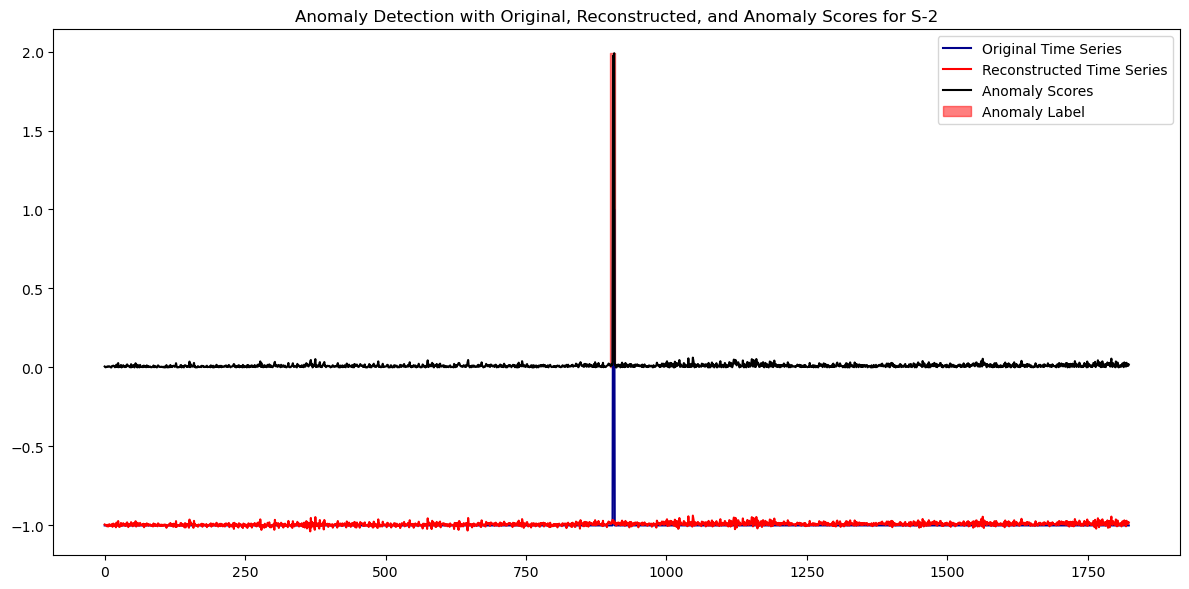

In [126]:
# Plotting trues, preds, and anomaly scores in one image
plt.figure(figsize=(12, 6))

# Plotting original time series (trues)
plt.plot(trues_S2[0, :], label='Original Time Series', c='darkblue')

# Plotting reconstructed time series (preds)
plt.plot(preds_S2[0, :], label='Reconstructed Time Series', c='red')

# Plotting anomaly scores
plt.plot(anomaly_scores_abs_S2[0, :], label='Anomaly Scores', c='black')

# Highlighting anomalies based on labels
plt.fill_between(range(anomaly_start_S2, anomaly_end_S2), min(anomaly_scores_abs_S2[0, :]), max(anomaly_scores_abs_S2[0, :]), 
                 where=(anomaly_scores_abs_S2[0, anomaly_start_S2:anomaly_end_S2] > 0), color='red', alpha=0.5, label='Anomaly Label')

plt.title('Anomaly Detection with Original, Reconstructed, and Anomaly Scores for S-2')
plt.legend()
plt.tight_layout()
plt.show()

ZERO-SHOT ANNOMALY DETECTION FOR P-10.NPY

In [127]:
# Load the data
P10path = 'H:/UNIVERSITY/Deep learning/Deep project/Dataset/data/data/test/P-10.npy'
data_P10 = np.load(P10path)

# Convert to PyTorch tensor
data_tensor_P10 = torch.tensor(data_P10, dtype=torch.float)

# Reshape the tensor
data_tensor_reshaped_P10 = data_tensor_P10.unsqueeze(0).permute(0, 2, 1)

print(f"Original Shape: {data_tensor_P10.shape}")
print(f"Reshaped Shape: {data_tensor_reshaped_P10.shape}")

Original Shape: torch.Size([6100, 55])
Reshaped Shape: torch.Size([1, 55, 6100])


In [128]:
# Move tensor to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor_reshaped_P10 = data_tensor_reshaped_P10.to(device)
print(data_tensor_reshaped_P10.shape)

torch.Size([1, 55, 6100])


In [130]:
data_tensor_reshaped_P10 = data_tensor_reshaped_P10[:, :, :6096]
print(f"Truncated shape: {data_tensor_reshaped_P10.shape}")# Perform inference
with torch.no_grad():
    output_P10 = model(data_tensor_reshaped_P10)

Truncated shape: torch.Size([1, 55, 6096])


d:\Users\arian\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
d:\Users\arian\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [131]:
# Extract reconstructed values
reconstruction_P10 = output_P10.reconstruction.squeeze().cpu().numpy()  # Reconstructed values
print(reconstruction_P10)

[[ 3.03747535e-01  5.22593319e-01  5.66018999e-01 ...  5.57100952e-01
   4.55172777e-01  6.99501753e-01]
 [-1.84669591e-06 -1.71440874e-07 -3.19336380e-07 ... -2.24456085e-06
   1.35837820e-06  1.42246631e-06]
 [-2.60517254e-06 -1.46331422e-06 -1.11165309e-06 ... -1.73929118e-06
  -1.37268700e-07 -6.97280029e-07]
 ...
 [-1.75102184e-06 -8.84944313e-07 -4.31578826e-07 ... -1.75356240e-06
  -2.77186736e-08 -1.12511586e-07]
 [-3.50125600e-03 -1.24857354e-03 -3.68406530e-04 ... -1.57467567e-03
   1.51025492e-03 -8.57323059e-04]
 [-2.76336493e-03 -7.77325244e-04 -5.67384064e-04 ... -1.05935298e-02
   1.45061268e-03  7.84757454e-03]]


In [134]:
# Original data
trues_P10 = data_tensor_reshaped_P10.squeeze().cpu().numpy() 
preds_P10 = reconstruction_P10

In [135]:
# Calculate anomaly scores
anomaly_scores_P10 = np.mean(np.square(trues_P10 - preds_P10), axis=0)

In [136]:
# Initialize labels
labels_P10 = np.zeros(trues_P10.shape[1])  # Initialize labels
labels_P10[4590:4720] = 1  # Anomaly range

In [137]:
# Calculate the zero-shot adjusted best F1 score
adjusted_best_f1_P10 = adjbestf1(y_true=labels_P10, y_scores=anomaly_scores_P10)
print(f"Zero-shot Adjusted Best F1 Score For P-10: {adjusted_best_f1_P10}")

Zero-shot Adjusted Best F1 Score For P-10: 0.955877292413599


In [138]:
# Calculate absolute anomaly scores for visualization
anomaly_scores_abs_P10 = np.abs(trues_P10 - preds_P10)

# Define start and end indices for visualization
anomaly_start_P10, anomaly_end_P10 = 4590, 4720

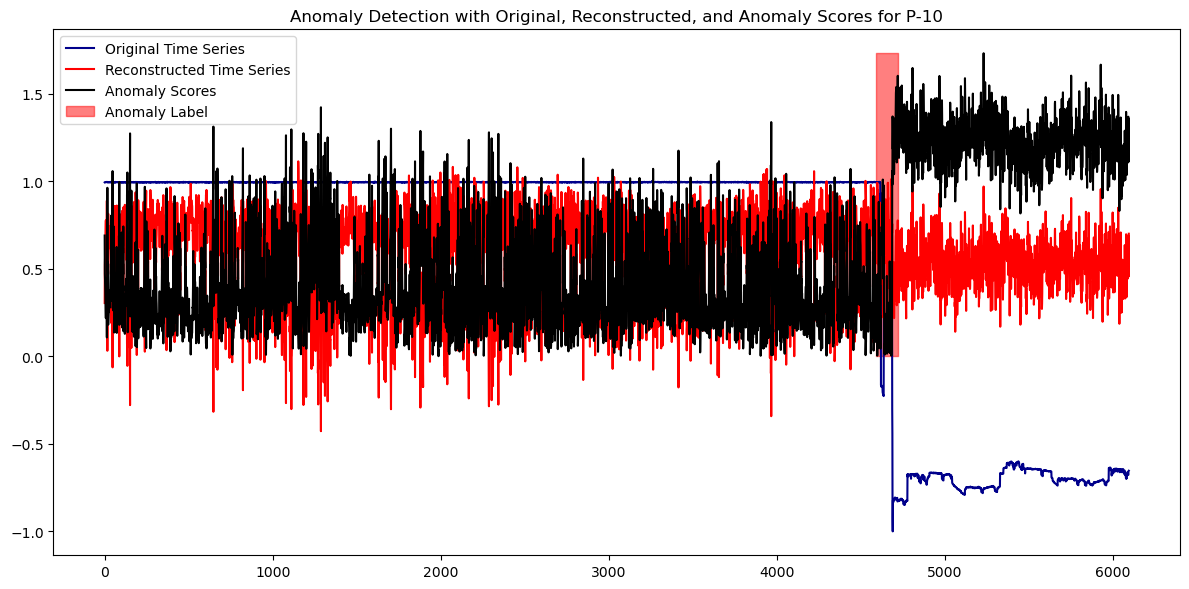

In [139]:
# Plotting trues, preds, and anomaly scores in one image
plt.figure(figsize=(12, 6))

# Plotting original time series (trues)
plt.plot(trues_P10[0, :], label='Original Time Series', c='darkblue')

# Plotting reconstructed time series (preds)
plt.plot(preds_P10[0, :], label='Reconstructed Time Series', c='red')

# Plotting anomaly scores
plt.plot(anomaly_scores_abs_P10[0, :], label='Anomaly Scores', c='black')

# Highlighting anomalies based on  labels
plt.fill_between(range(anomaly_start_P10, anomaly_end_P10), min(anomaly_scores_abs_P10[0, :]), max(anomaly_scores_abs_P10[0, :]), 
                 where=(anomaly_scores_abs_P10[0, anomaly_start_P10:anomaly_end_P10] > 0), color='red', alpha=0.5, label='Anomaly Label')

plt.title('Anomaly Detection with Original, Reconstructed, and Anomaly Scores for P-10')
plt.legend()
plt.tight_layout()
plt.show()

ZERO-SHOT ANNOMALY DETECTION FOR D-15.NPY

In [140]:
# Load the data
D15path = 'H:/UNIVERSITY/Deep learning/Deep project/Dataset/data/data/test/D-15.npy'
data_D15 = np.load(D15path)

# Convert to PyTorch tensor
data_tensor_D15 = torch.tensor(data_D15, dtype=torch.float)

# Reshape the tensor
data_tensor_reshaped_D15 = data_tensor_D15.unsqueeze(0).permute(0, 2, 1)

print(f"Original Shape: {data_tensor_D15.shape}")
print(f"Reshaped Shape: {data_tensor_reshaped_D15.shape}")

Original Shape: torch.Size([2158, 55])
Reshaped Shape: torch.Size([1, 55, 2158])


In [141]:
# Move tensor to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor_reshaped_D15 = data_tensor_reshaped_D15.to(device)
print(data_tensor_reshaped_D15.shape)

torch.Size([1, 55, 2158])


In [143]:
data_tensor_reshaped_D15 = data_tensor_reshaped_D15[:, :, :2152]
print(f"Truncated shape: {data_tensor_reshaped_D15.shape}")# Perform inference
with torch.no_grad():
    output_D15 = model(data_tensor_reshaped_D15)

Truncated shape: torch.Size([1, 55, 2152])


d:\Users\arian\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
d:\Users\arian\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [144]:
# Extract reconstructed values
reconstruction_D15 = output_D15.reconstruction.squeeze().cpu().numpy()  # Reconstructed values
print(reconstruction_D15)

[[ 1.1111999e+00  9.4633913e-01  7.3610467e-01 ...  7.6837957e-01
   9.3829298e-01  9.0454972e-01]
 [ 1.5568805e-06  6.6229923e-08 -4.1564573e-07 ... -8.1627093e-07
   1.4040271e-06  1.6067070e-06]
 [-7.7762900e-07 -2.8419859e-07 -9.3612692e-07 ...  5.8960887e-07
   9.6153292e-07 -8.3076924e-07]
 ...
 [ 4.7060510e-07 -6.0279950e-07 -2.8074919e-07 ... -1.4846780e-06
   2.6186547e-06  9.3675277e-07]
 [ 1.1373782e-03 -1.7042629e-03 -1.4643922e-03 ...  7.1012136e-03
  -1.1692094e-04  2.9005213e-03]
 [ 1.3911026e-07 -3.2566447e-07 -8.2533739e-07 ...  1.0621685e-06
  -3.5823373e-07 -6.0804427e-07]]


In [145]:
# Original data
trues_D15 = data_tensor_reshaped_D15.squeeze().cpu().numpy() 
preds_D15 = reconstruction_D15

In [146]:
# Calculate anomaly scores
anomaly_scores_D15 = np.mean(np.square(trues_D15 - preds_D15), axis=0)

In [147]:
# Initialize labels
labels_D15 = np.zeros(trues_D15.shape[1])  # Initialize labels
labels_D15[1500:2140] = 1  # Anomaly range

In [148]:
# Calculate the zero-shot adjusted best F1 score
adjusted_best_f1_D15 = adjbestf1(y_true=labels_D15, y_scores=anomaly_scores_D15)
print(f"Zero-shot Adjusted Best F1 Score For D-15: {adjusted_best_f1_D15}")

Zero-shot Adjusted Best F1 Score For D-15: 0.9891758199431384


In [149]:
# Calculate absolute anomaly scores for visualization
anomaly_scores_abs_D15 = np.abs(trues_D15 - preds_D15)

# Define start and end indices for visualization
anomaly_start_D15, anomaly_end_D15 = 1500,2140

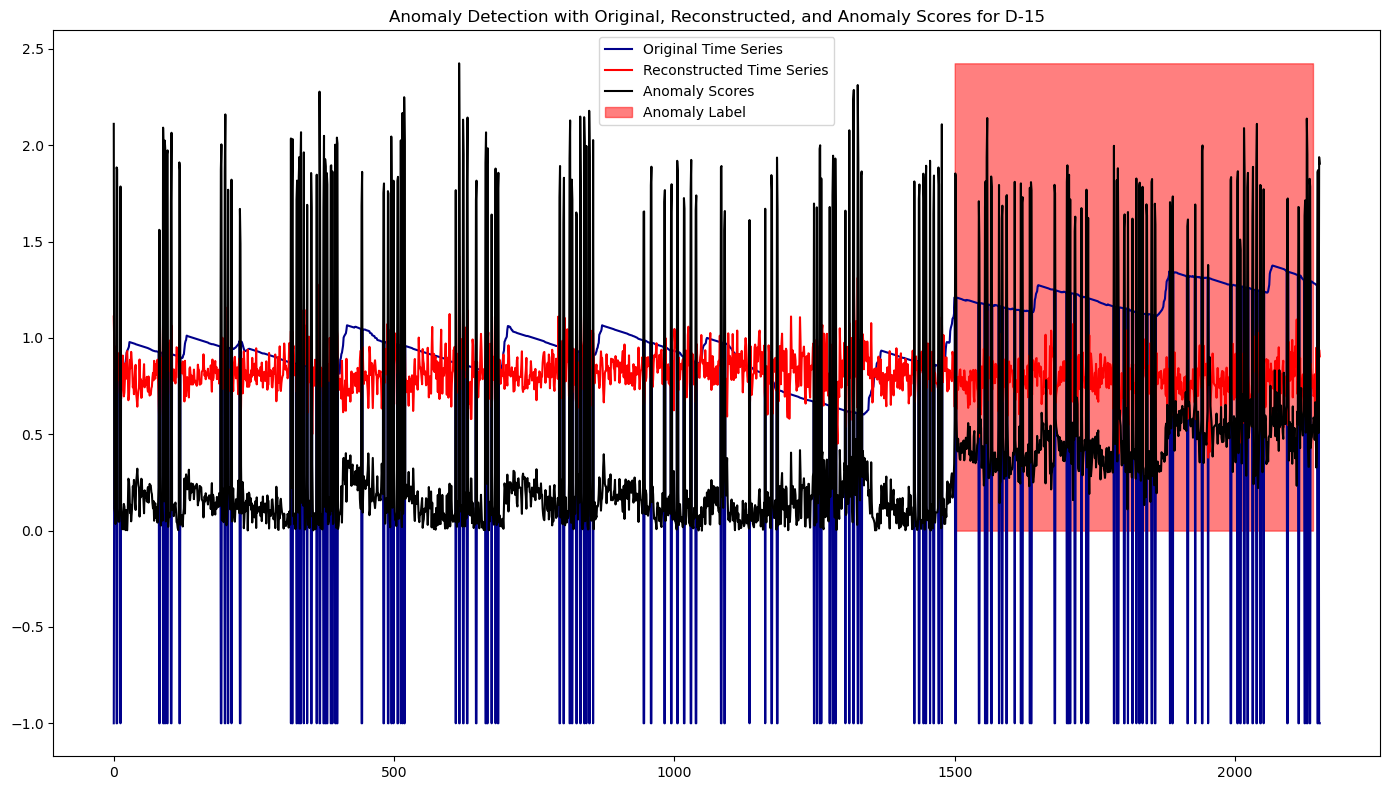

In [153]:
# Plotting trues, preds, and anomaly scores in one image
plt.figure(figsize=(14, 8))

# Plotting original time series (trues)
plt.plot(trues_D15[0, :], label='Original Time Series', c='darkblue')

# Plotting reconstructed time series (preds)
plt.plot(preds_D15[0, :], label='Reconstructed Time Series', c='red')

# Plotting anomaly scores
plt.plot(anomaly_scores_abs_D15[0, :], label='Anomaly Scores', c='black')

# Highlighting anomalies based on  labels
plt.fill_between(range(anomaly_start_D15, anomaly_end_D15), min(anomaly_scores_abs_D15[0, :]), max(anomaly_scores_abs_D15[0, :]), 
                 where=(anomaly_scores_abs_D15[0, anomaly_start_D15:anomaly_end_D15] > 0), color='red', alpha=0.5, label='Anomaly Label')

plt.title('Anomaly Detection with Original, Reconstructed, and Anomaly Scores for D-15')
plt.legend()
plt.tight_layout()
plt.show()